In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import scipy.signal as signal
from scipy.signal import find_peaks
import shutil

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, fs=fs, btype='low', analog=False)
    y = signal.lfilter(b, a, data)
    return y

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff,fs=fs, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

peaks:[2645]


(2565, 3925)

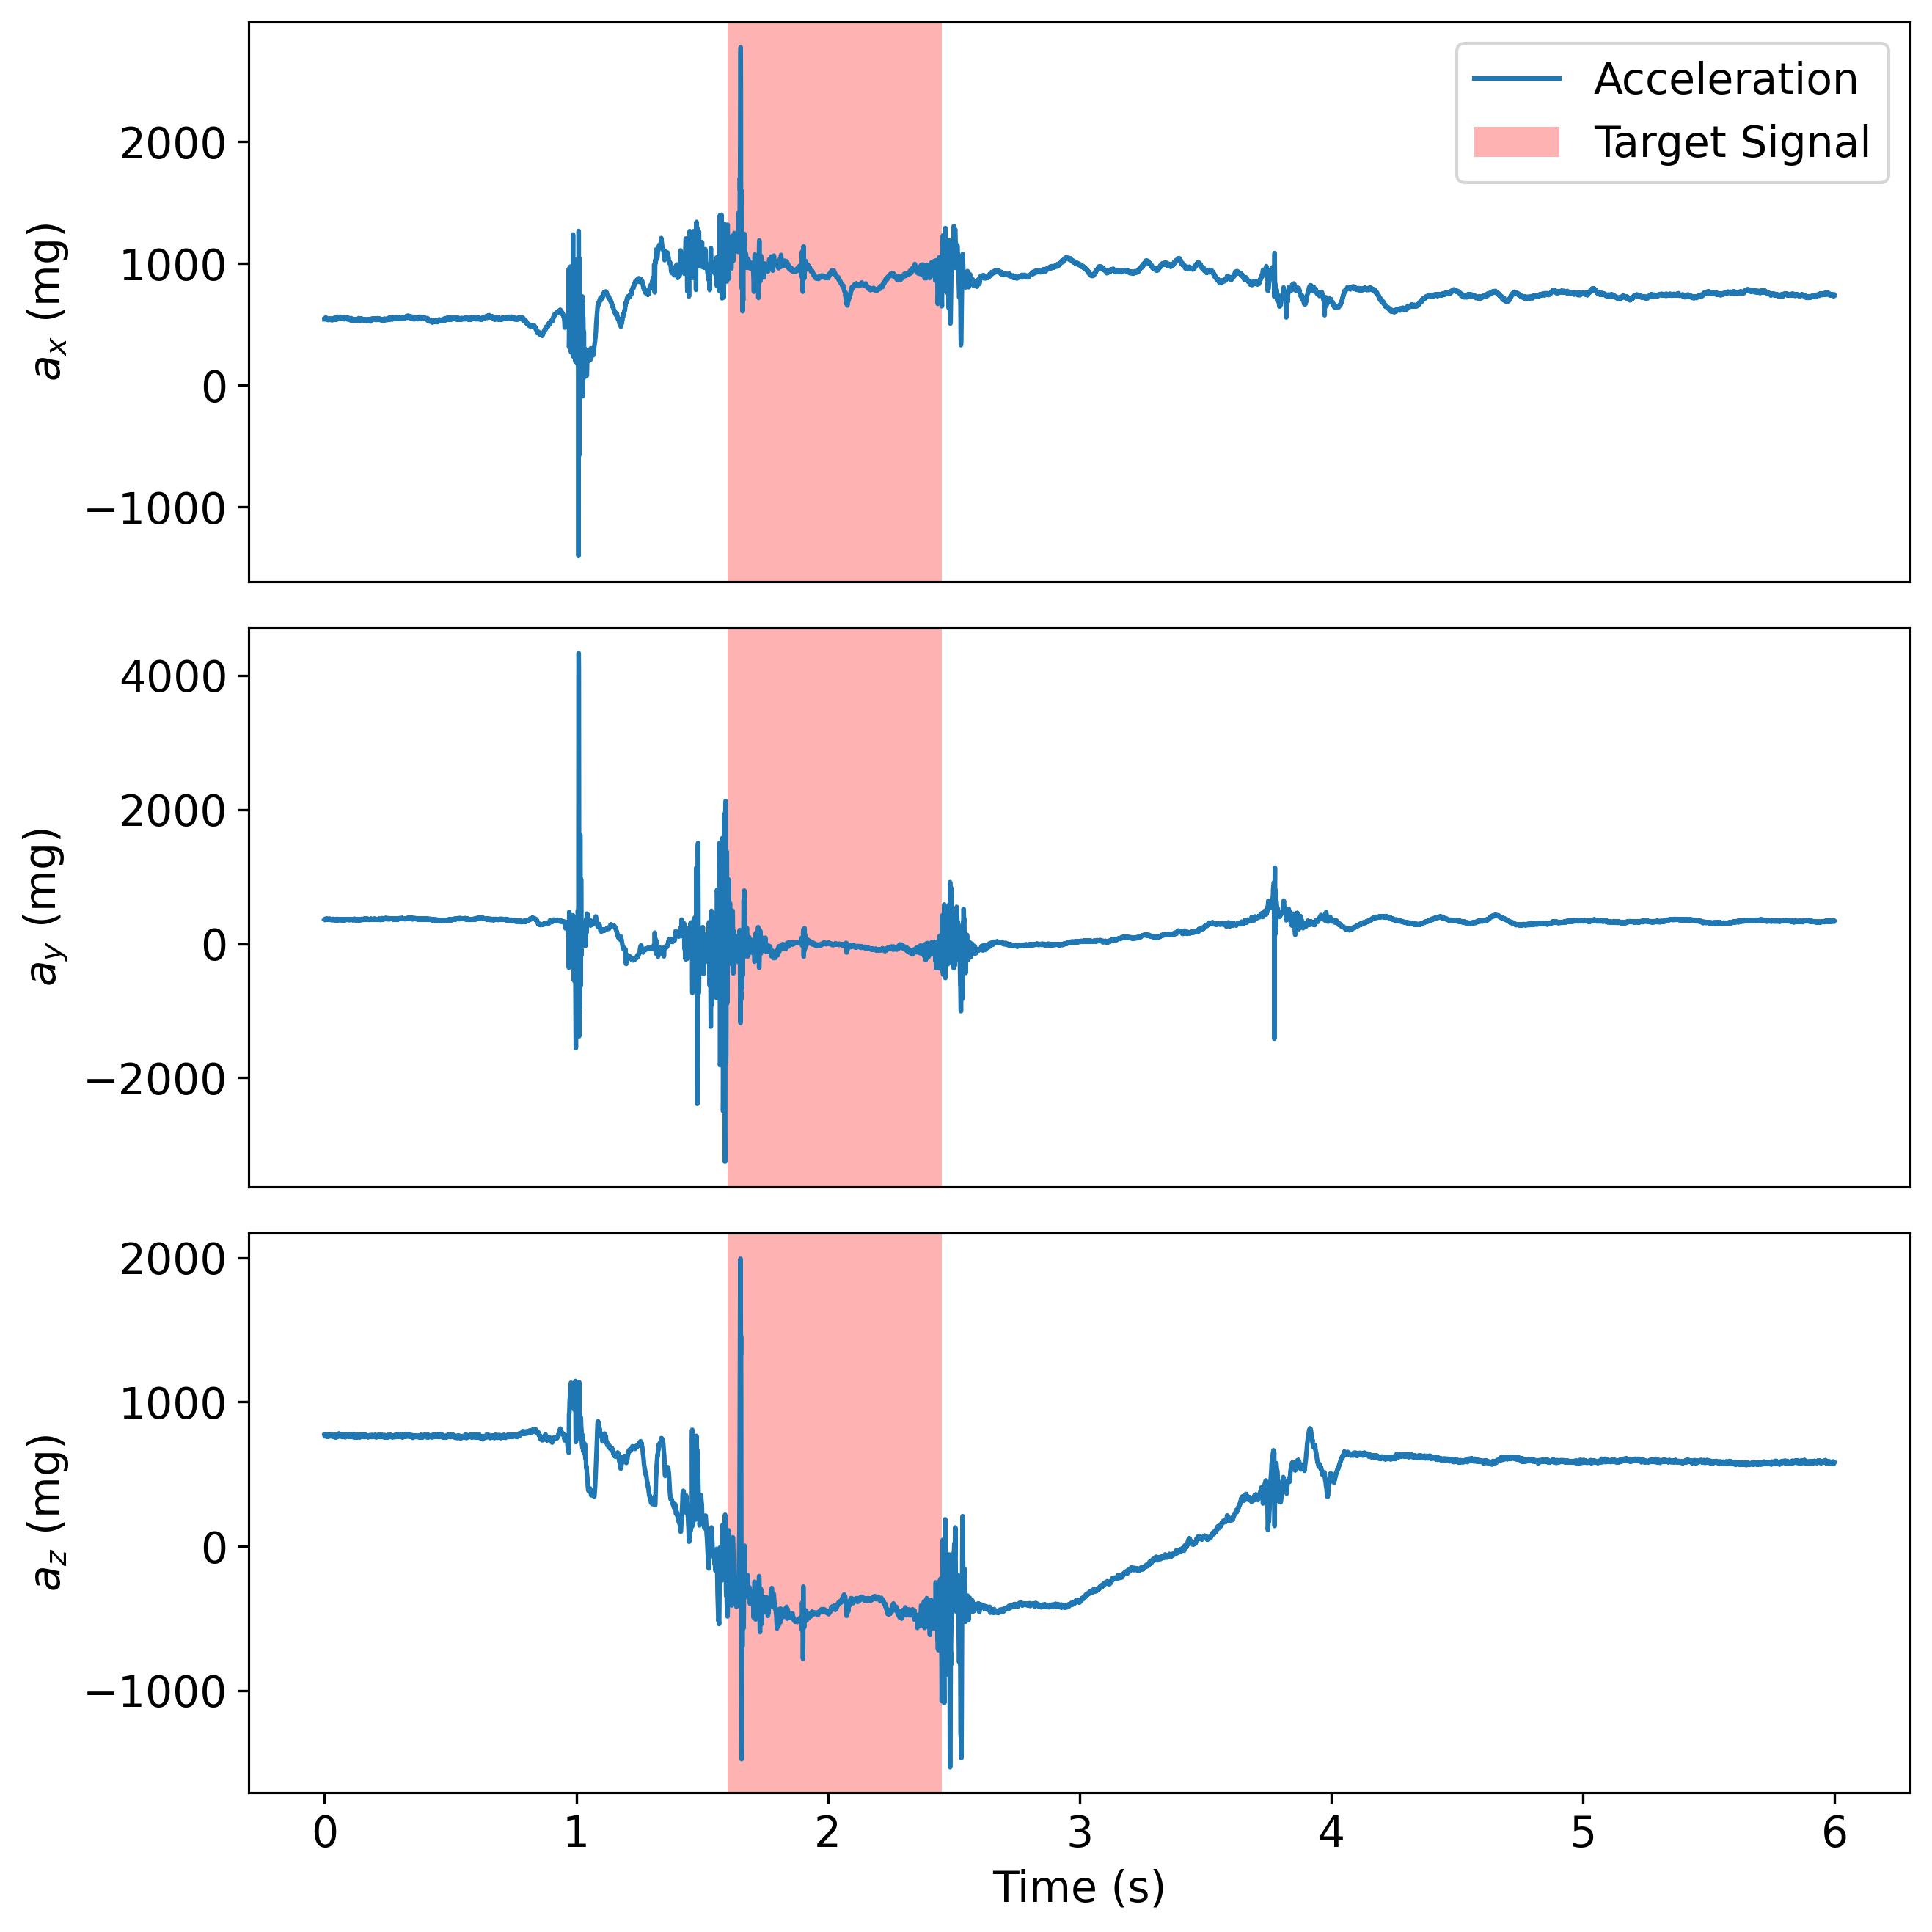

In [68]:
# 数据清洗部分

# 滤波绘制
def plot_data(filename,fs=1330,forward=0.5,backward=0.7,success=True):
    plt.rc('font', size=14, family='DejaVu Sans') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
    plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
    
    df = pd.read_csv(filename)
    ACC_X = df['ACC_X']
    ACC_Y = df['ACC_Y']
    ACC_Z = df['ACC_Z']

    # accData = np.genfromtxt(filename, delimiter=",")
    # ACC_X = accData[:, 0]
    # ACC_Y = accData[:, 1]
    # ACC_Z = accData[:, 2]
    # print(ACC_Z)
    time = np.arange(len(ACC_Z)) / fs

    # time = df['Time']

    # 滤波参数
    # fs2 = 1/np.mean(np.diff(time))
    # print(f"fs2:{fs2}")
    # plt.specgram(ACC_Z, NFFT=1024, Fs=1330, detrend='linear')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Frequency (Hz)')
    # plt.colorbar(label='Intensity')
    # if success:
    #     plt.title('Spectrogram - Successful State')
    # else:
    #     plt.title('Spectrogram - Failed State')
    cutoff_L,cutoff_H = 500,20
    order_L,order_H = 6,5
    truncate_length = 0
    
    ACC_Z_filtered_L = butter_lowpass_filter(ACC_Z, cutoff_L, fs, order_L)
    ACC_Z_filtered_H = butter_highpass_filter(ACC_Z_filtered_L, cutoff_H, fs, order_H)[truncate_length:]
    time = time[truncate_length:]

    # 截取窗口
    threshold = 1000 
    peaks, _ = find_peaks(ACC_Z_filtered_H, height=threshold)
    print(f"peaks:{peaks}")
    pivot = peaks[0]
    start_index = pivot - int(forward*fs)
    end_index = pivot + int(backward*fs)
    # print("index:",start_index,end_index)
    
    
    fig, axes = plt.subplots(3, 1, figsize=(9, 9),dpi=300)
    
    axes[0].plot(time,ACC_X, label='Acceleration')
    axes[1].plot(time,ACC_Y)
    axes[2].plot(time,ACC_Z)
        
    axes[0].axvspan(time[start_index], time[end_index], facecolor='red', alpha=0.3, label='Target Signal')
    axes[0].set_ylabel('Acceleration of X (mg)')
    axes[0].set_ylabel('$a_x$ (mg)')
    axes[0].legend()
    axes[1].axvspan(time[start_index], time[end_index], facecolor='red', alpha=0.3)
    axes[1].set_ylabel('$a_y$ (mg)')
    axes[2].axvspan(time[start_index], time[end_index], facecolor='red', alpha=0.3)
    axes[2].set_ylabel('$a_z$ (mg)')
    
    axes[0].set_xticks([])
    axes[1].set_xticks([])
    axes[2].set_xlabel("Time (s)")
    
    plt.tight_layout()
    # plt.show()
    if success:
        plt.savefig('../img/success.png')
        
    else:
        plt.savefig('../img/failed.png')
        
    return start_index,end_index

# 裁剪目标波形 
def crop_data(filepath, newfoldername, fs=1330,forward=0.5,backward=1):
    
    newfilepath = os.path.join('.', newfoldername, os.path.basename(filepath))

    df = pd.read_csv(filepath)
    ACC = df['ACC_Z']
    time = df['Time']

    # fs = 1/np.mean(np.diff(time))
    truncate_length = 0
    
    ACC_filtered_L = butter_lowpass_filter(ACC, cutoff=500, fs=fs, order=6)
    ACC_filtered_H = butter_highpass_filter(ACC_filtered_L, cutoff=20, fs=fs, order=5)[truncate_length:]
    time = time.values[truncate_length:]
    
    threshold = 1000 
    peaks, _ = find_peaks(ACC_filtered_H, height=threshold)
    pivot = peaks[0]
    start_index = pivot - int(forward*fs)
    end_index = pivot + int(backward*fs)
    
    df_cropped = df[start_index:end_index + 1]
    
    
    # 获取目录部分
    directory = os.path.dirname(newfilepath)

    # 如果目录不存在，则递归创建目录
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    
    df_cropped.to_csv(newfilepath, index=False)
    return newfilepath
   
# 根据标签文件，裁剪目标波形
def clean_data(labelfile, target_folder, fs,forward=0.5,backward=1.5):
    
    df = pd.read_csv(labelfile)
    
    for index, row in df.iterrows():
        filepath = row.iloc[0]
        # plot_data(filepath)
        new_file_path = crop_data(filepath, target_folder, fs, forward, backward)

        # 检查裁剪后的文件的行数，避免出现错误数据
        with open(new_file_path, 'r') as csv_file:
            csv_reader = csv.reader(csv_file)
        
            row_count = len(list(csv_reader))
            print(f"{new_file_path} has {row_count} rows")
            
    df['FilePath'] = df['FilePath'].apply(lambda x: x.replace('output', target_folder))
    # new_label_file_path = './label_file_replaced.csv'
    new_label_file_path = target_folder+'_label_file.csv'
    df.to_csv(new_label_file_path, index=False)



newfoldername = '../data'
forward = 0.05
backward = 0.8
# fs=1330
fs=1600
# clean_data('./label_file.csv',newfoldername, fs, forward,backward)

# crop_data('./output/20240104_091258.csv', newfoldername)

# toilet_roll
plot_data('../data/toilet_roll/Sensor1_20240425-095920.csv',fs,forward,backward,False)
# plot_data('../data/toilet_roll/Sensor1_20240425-095651.csv',fs,forward,backward,True)

# white_cup
# plot_data('../data/white_cup_user1/20240305_200436.csv',fs,forward,backward,False)
# plot_data('../data/ping_pong/Sensor1_20240425-193830.csv',fs,forward,backward,True)

# crop_data('../data/white_cup_user1/20240104_091258.csv',newfoldername)

fs2:1331.8221968843848
index: 1274 3269


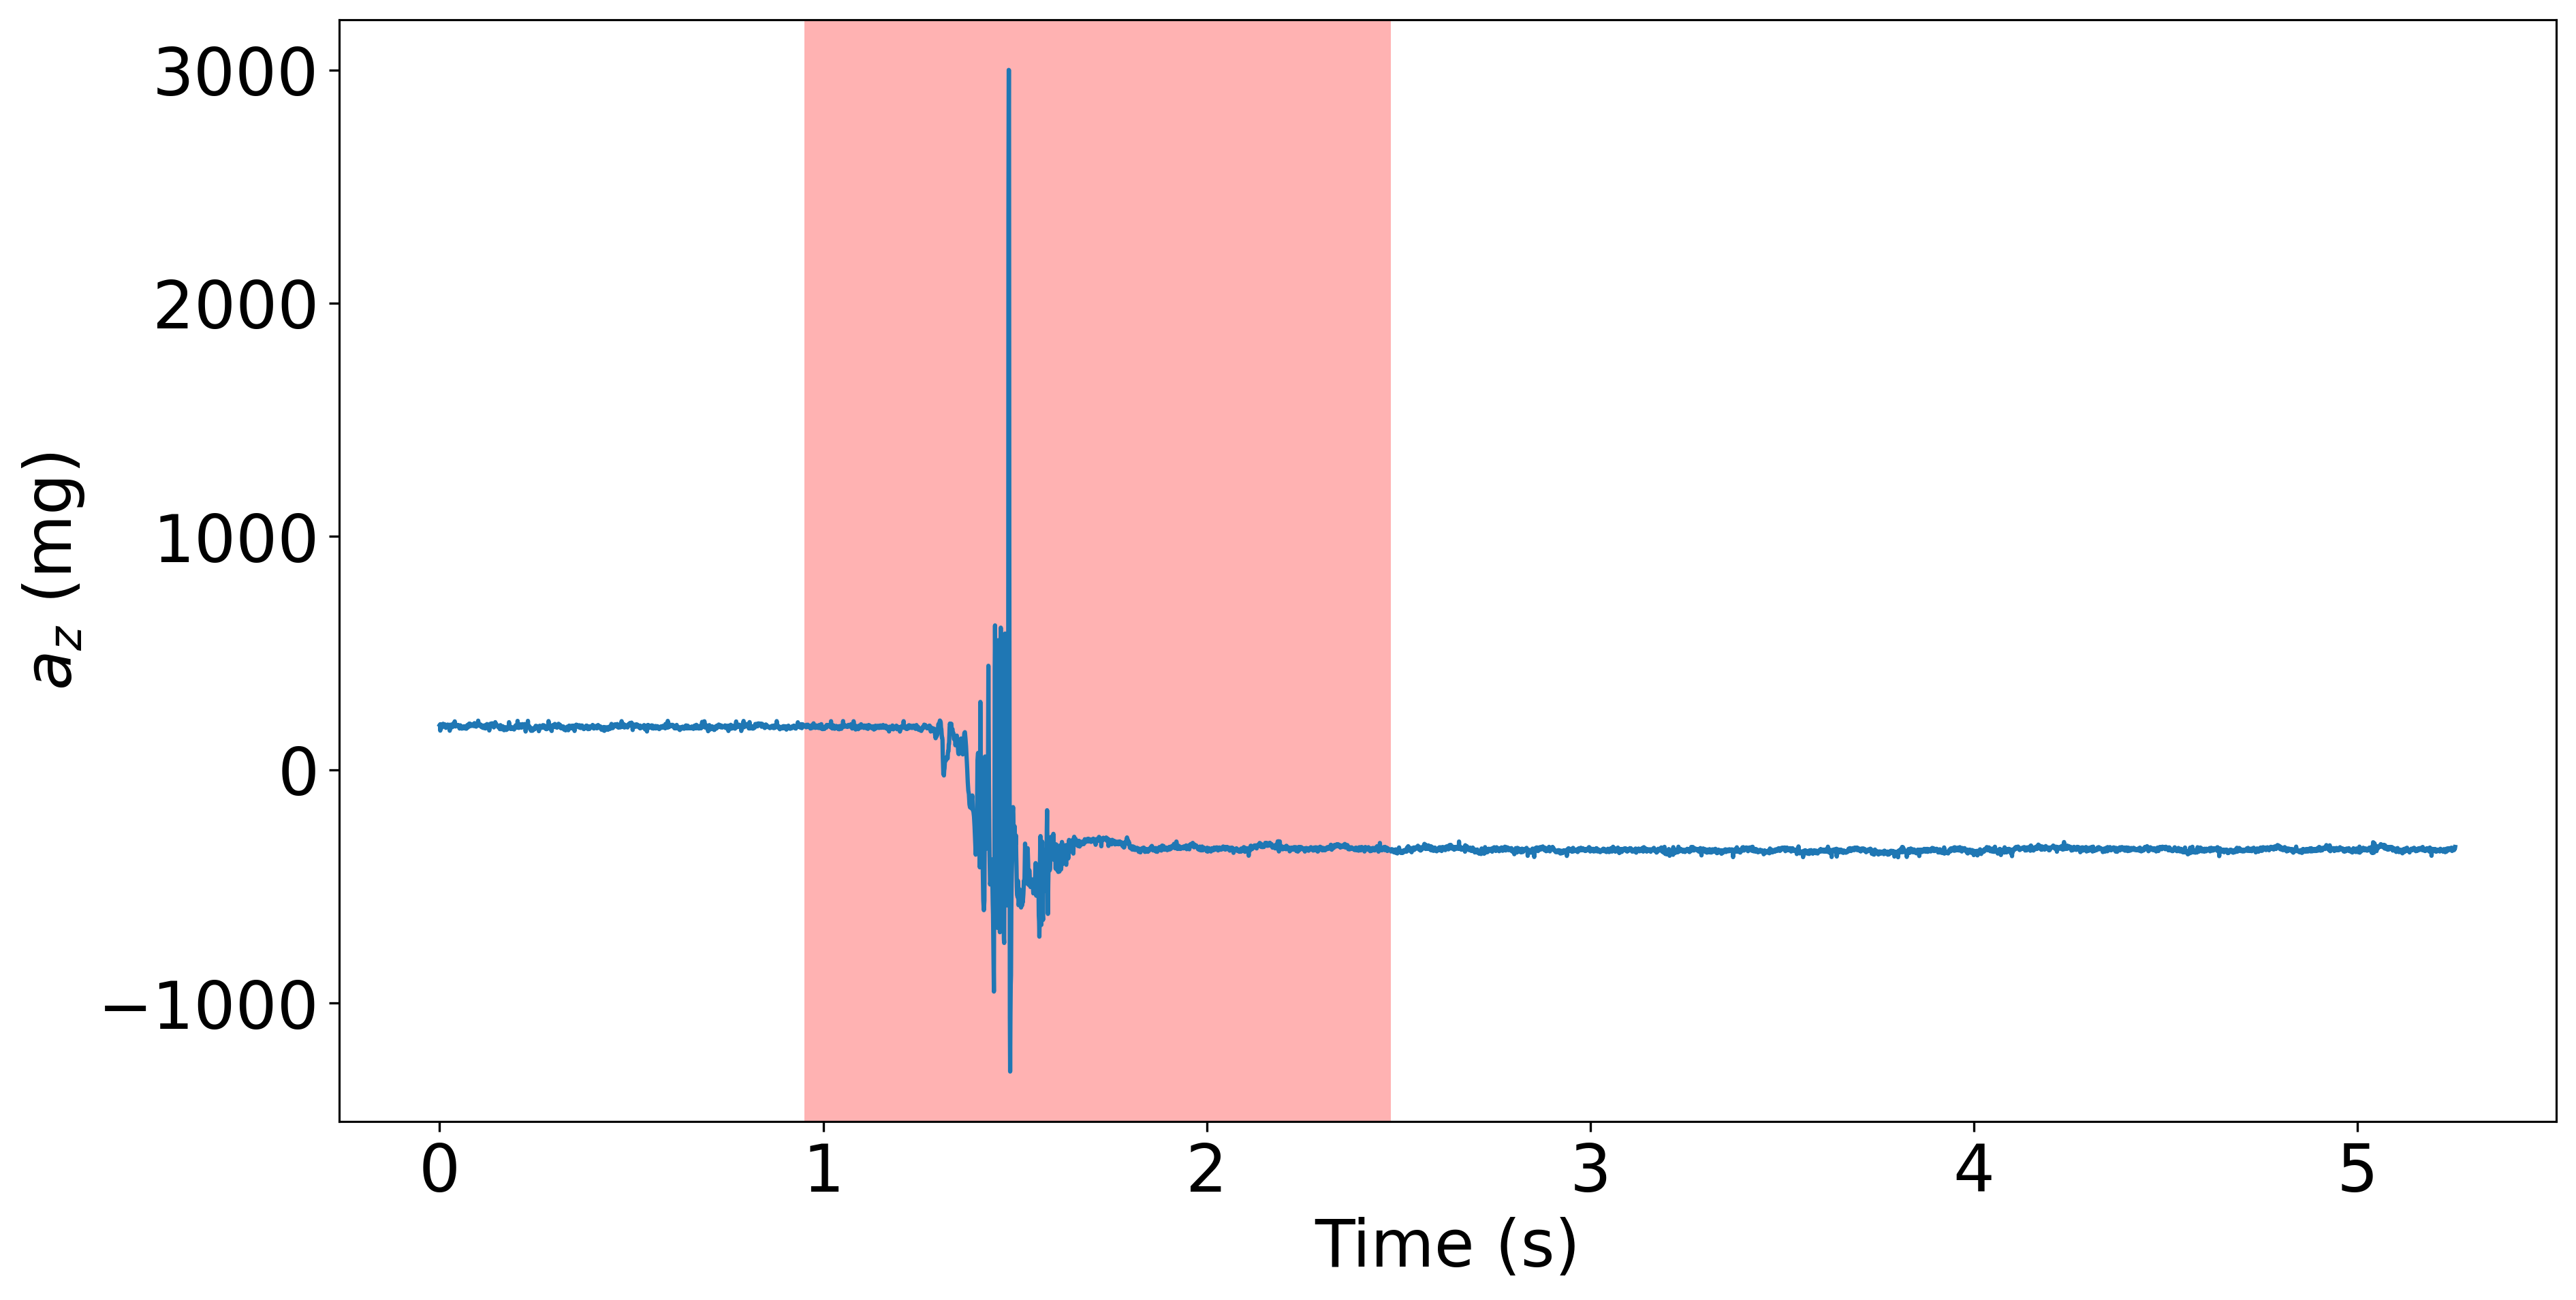

In [24]:
def plot_single_data(filename,fs=1330,forward=0.5,backward=0.7):
    plt.rc('font', size=23, family='DejaVu Sans') # 'Tahoma', 'DejaVu Sans', 'Verdana'"
    plt.rc('axes', edgecolor='k', linewidth=0.75, labelcolor='k')
    df = pd.read_csv(filename)
    ACC_Z = df['ACC_Z']
    time = df['Time']

    # 滤波参数
    fs2 = 1/np.mean(np.diff(time))
    print(f"fs2:{fs2}")
    cutoff_L,cutoff_H = 500,20
    order_L,order_H = 6,5
    truncate_length = 0
    
   
    ACC_Z_filtered_L = butter_lowpass_filter(ACC_Z, cutoff_L, fs, order_L)
    ACC_Z_filtered_H = butter_highpass_filter(ACC_Z_filtered_L, cutoff_H, fs, order_H)[truncate_length:]
    time = time.values[truncate_length:]

    # 截取窗口
    threshold = 1000 
    peaks, _ = find_peaks(ACC_Z_filtered_H, height=threshold)
    pivot = peaks[0]
    start_index = pivot - int(forward*fs)
    end_index = pivot + int(backward*fs)
    print("index:",start_index,end_index)
    fig, ax = plt.subplots(figsize=(14,7),dpi=300)
    ax.axvspan(time[start_index], time[end_index], facecolor='red', alpha=0.3, label='Target Waveform')
    
    ax.set_ylabel('$a_z$ (mg)')
    ax.set_xlabel('Time (s)')
    # plt.tight_layout()  # 调整图表的布局
    
    plt.plot(time,ACC_Z, label='ACC_Z Data')
    # plt.savefig()
    plt.savefig('../img/signal.png')
    
    plt.show()
    
    return

forward = 0.5
backward = 1

plot_single_data('../data/white_cup_user1/20240104_091258.csv',fs,forward,backward)



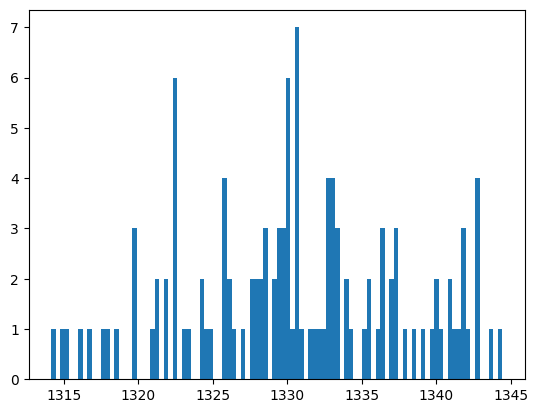

1330.4837978245776

In [15]:
def sr_check(labelFile):
    df = pd.read_csv(labelFile)
    filepaths = df['FilePath']
    n = len(filepaths)
    srs = np.empty(n)
    for ind,filepath in enumerate(filepaths):
        t = pd.read_csv(filepath)['Time']
        # print('t',t)
        # s = t.to_numpy(dtype=int)
        # print('s',s)
        srs[ind] = 1/np.mean(np.diff(t))
    
    plt.hist(srs, 100)
    plt.show()
    return np.mean(srs)

sr_check('label_file.csv')